# ALPR (Automatic License Plate Recognition)
Using code from http://sergiomsilva.com/pubs/alpr-unconstrained/ with pre-trained model. Data from BEM.

Just clone code from https://github.com/sergiomsilva/alpr-unconstrained, install following the instruction, and put this notebook in the same folder to run.

## Method

![Method Overview](diagram.png) 

* Vehicle Detection: Pretrained YOLOv2 (to detect car and bus categories)
* License Plate (LP) Detection and Rectification: WPOD-NET composes of two sub-networks:
    * One detects the LP from a cropped image of car, and 
    * Another one regresses the coefficients of an affine transformation that distorts LP into a rectangular shape. Although a planar perspective projection could be learned, the division involved in the perspective transformation might generate small values in the denominator, and hence leading to numerical instabilities.
* Optical Character Recognition (OCR): A modified YOLO network named OCR-NET.

In [1]:
import os
import numpy as np
import pandas as pd
import cv2

import matplotlib as mpl
from matplotlib import pyplot as plt
from __future__ import unicode_literals
%matplotlib inline
mpl.rc('font', family='Your Font')

In [2]:
# download font file มาก่อน
!wget https://awards.opdc.go.th/awards_opdc/assets/fonts/THSarabunNew/THSarabunNew.ttf
# import and install
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = fm.createFontList(['THSarabunNew.ttf'])
fm.fontManager.ttflist.extend(font_list)
# set font
plt.rcParams['font.family'] = 'TH Sarabun New'

--2019-04-24 08:37:34--  https://awards.opdc.go.th/awards_opdc/assets/fonts/THSarabunNew/THSarabunNew.ttf
Resolving awards.opdc.go.th (awards.opdc.go.th)... 164.115.18.46
Connecting to awards.opdc.go.th (awards.opdc.go.th)|164.115.18.46|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2019-04-24 08:37:34 ERROR 500: Internal Server Error.



In [3]:
input_dir = 'data/bem-lp'
label_file = '%s/transaction-pic-20-04-08.txt' % input_dir
label_csv = pd.read_csv(label_file, encoding='utf-8')
print('No. of labels = %s' % len(label_csv))
print(label_csv.columns)

No. of labels = 7265
Index([u'CSCV_PLATE_NO', u'CSCT_CONTRACT_ID', u'CSPX_PLAZA_ID',
       u'CSPX_LANE_ID', u'CSPX_TRX_DATETIME', u'CSPX_PICTURE_FILE_NAME',
       u'CSPX_SIGNAL_CODE', u'PATHFILE'],
      dtype='object')


In [4]:
from glob import glob
file_list = glob('%s/08/*.jif' % input_dir)
print('No. of images in the folder = %s' % len(file_list))

No. of images in the folder = 14772


In [5]:
label_csv = label_csv[['CSCV_PLATE_NO', 'PATHFILE']]

In [6]:
idx1 = [lp.strip() != '-' for lp in label_csv.CSCV_PLATE_NO]
label_csv = label_csv[idx1]
print('No. of images after removing "-" = %s' % len(label_csv))

No. of images after removing "-" = 6632


In [7]:
idx2 = [os.path.isfile('%s/%s' % (input_dir, lp_file)) for lp_file in label_csv.PATHFILE]
label_csv = label_csv[idx2]
print('No. of images with label = %s' % len(label_csv))

No. of images with label = 6622


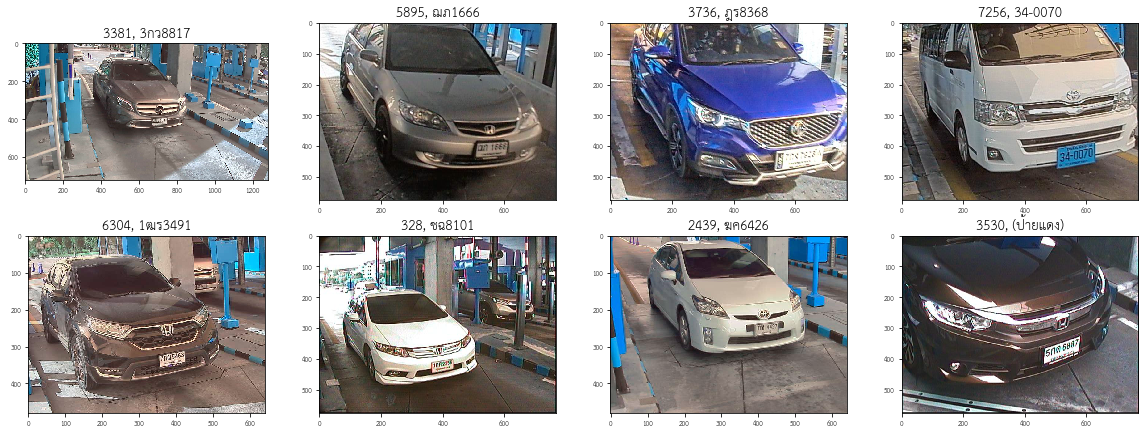

In [8]:
ids = np.random.permutation(label_csv.index)
plt.figure(figsize=(20,15))
for i in range(8):
    img_path = '%s%s' % (input_dir, label_csv.PATHFILE[ids[i]])
    Ivehicle = cv2.imread(img_path)
    h, w, _ = Ivehicle.shape
    if w/float(h) > 2:
        Ivehicle = cv2.resize(Ivehicle, (w,h*2))
    plt.subplot(4,4,i+1)
    plt.imshow(Ivehicle)
    plt.title('%d, %s' % (ids[i], label_csv.CSCV_PLATE_NO[ids[i]]), fontsize=20)
plt.show()

## Vehicle Detection

In [9]:
from vehicledetection import vehicle_detection

veh_input_dir = '%s%s' % (input_dir, os.path.dirname(label_csv.PATHFILE[0]))
veh_output_dir = 'result/vehicle_detection'
if not os.path.isdir(veh_output_dir):
    os.mkdir(veh_output_dir)
print('Input Folder:', veh_input_dir)
print('Output Folder:', veh_output_dir)

(u'Input Folder:', u'data/bem-lp/08')
(u'Output Folder:', u'result/vehicle_detection')


In [10]:
import sys
import cv2
import numpy as np
import traceback

import darknet.python.darknet as dn

from src.label 				import Label, lwrite
from os.path 				import splitext, basename, isdir
from os 					import makedirs
from src.utils 				import crop_region, image_files_from_folder
from darknet.python.darknet import detect

In [11]:
def vehicle_detection(input_dir, output_dir, num_imgs=50):
    vehicle_threshold = .5

    vehicle_weights = 'data/vehicle-detector/yolo-voc.weights'
    vehicle_netcfg  = 'data/vehicle-detector/yolo-voc.cfg'
    vehicle_dataset = 'data/vehicle-detector/voc.data'

    vehicle_net  = dn.load_net(vehicle_netcfg, vehicle_weights, 0)
    vehicle_meta = dn.load_meta(vehicle_dataset)

    imgs_paths = image_files_from_folder(input_dir)
    imgs_paths.sort()

    if not isdir(output_dir):
        makedirs(output_dir)

    print 'Searching for vehicles using YOLO...'

    for i,img_path in enumerate(imgs_paths):
        
        print '\tScanning %s' % img_path
        bname = basename(splitext(img_path)[0])
        R,_ = detect(vehicle_net, vehicle_meta, img_path ,thresh=vehicle_threshold)
        R = [r for r in R if r[0] in ['car','bus']]
        print '\t\t%d cars found' % len(R)
        if len(R):
            Iorig = cv2.imread(img_path)
            WH = np.array(Iorig.shape[1::-1],dtype=float)
            Lcars = []

            for j,r in enumerate(R):
                cx,cy,w,h = (np.array(r[2])/np.concatenate( (WH,WH) )).tolist()
                tl = np.array([cx - w/2., cy - h/2.])
                br = np.array([cx + w/2., cy + h/2.])
                label = Label(0,tl,br)
                Icar = crop_region(Iorig,label)

                Lcars.append(label)
                cv2.imwrite('%s/%s_%dcar.png' % (output_dir,bname,j),Icar)
            lwrite('%s/%s_cars.txt' % (output_dir,bname),Lcars)
        if i > num_imgs:
            print('%d images done.' % num_imgs)
            break


In [12]:
vehicle_detection(veh_input_dir, veh_output_dir)

Searching for vehicles using YOLO...
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_00_04_S0003273528.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_00_14_S0002765275.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_00_20_S0003273529.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_09_S0002765276.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_13_S0002765277.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_16_S0003273530.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_41_S0002765278.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_42_S0003273531.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_47_S0003273532.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_49_S0002765279.jif
		1 cars found
	Scanning data/bem-lp/08/P201_L01_F_D2019_04_20_T08_01_53_S0003273533.jif

## License Plate Detection

In [13]:
wpod_net_path = "data/lp-detector/wpod-net_update1.h5"
print('WPod model:', wpod_net_path)

(u'WPod model:', u'data/lp-detector/wpod-net_update1.h5')


In [14]:
import sys, os

import keras
import cv2
import traceback

from src.keras_utils 			import load_model
from glob 						import glob
from os.path 					import splitext, basename
from src.utils 					import im2single
from src.keras_utils 			import load_model, detect_lp
from src.label 					import Shape, writeShapes
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

Using TensorFlow backend.


In [15]:
lp_threshold = .5

wpod_net = load_model(wpod_net_path)

imgs_paths = glob('%s/*car.png' % veh_output_dir)

print('Searching for license plates using WPOD-NET')

Instructions for updating:
Colocations handled automatically by placer.
Searching for license plates using WPOD-NET


In [16]:
for i,img_path in enumerate(imgs_paths):
    print('\t Processing %s' % img_path)

    bname = splitext(basename(img_path))[0]
    Ivehicle = cv2.imread(img_path)
    h, w, _ = Ivehicle.shape
    if w/float(h) > 2:
        Ivehicle = cv2.resize(Ivehicle, (w,h*2))
    
    ratio = float(max(Ivehicle.shape[:2]))/min(Ivehicle.shape[:2])
    side  = int(ratio*288.)
    bound_dim = min(side + (side%(2**4)),608)
    print("\t\tBound dim: %d, ratio: %f" % (bound_dim,ratio))

    Llp,LlpImgs,_ = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold)

    if len(LlpImgs):
        Ilp = LlpImgs[0]
        Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
        Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)

        s = Shape(Llp[0].pts)

        cv2.imwrite('%s/%s_lp.png' % (veh_output_dir,bname),Ilp*255.)
        writeShapes('%s/%s_lp.txt' % (veh_output_dir,bname),[s])

	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_09_35_S0003273551_0car.png
		Bound dim: 432, ratio: 1.500000
	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_01_49_S0002765279_0car.png
		Bound dim: 386, ratio: 1.338776
	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_08_09_S0002765295_0car.png
		Bound dim: 470, ratio: 1.623737
	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_00_20_S0003273529_0car.png
		Bound dim: 412, ratio: 1.385135
	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_01_13_S0002765277_0car.png
		Bound dim: 374, ratio: 1.261905
	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_05_47_S0002765290_0car.png
		Bound dim: 408, ratio: 1.404018
	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_09_32_S0003273550_0car.png
		Bound dim: 406, ratio: 1.401826
	 Processing result/vehicle_detection/P201_L01_F_D2019_04_20_T08_06_59_S0002765294_0car.png
		Bound dim: 444, ratio: 1

## Output

In [17]:
import sys
import cv2
import numpy as np

from glob						import glob
from os.path 					import splitext, basename, isfile
from src.utils 					import crop_region, image_files_from_folder
from src.drawing_utils			import draw_label, draw_losangle, write2img
from src.label 					import lread, Label, readShapes

from pdb import set_trace as pause

YELLOW = (  0,255,255)
RED    = (  0,  0,255)

P201_L01_F_D2019_04_20_T08_06_59_S0002765294
P201_L01_F_D2019_04_20_T08_00_04_S0003273528
P201_L01_F_D2019_04_20_T08_06_07_S0002765292
P201_L01_F_D2019_04_20_T08_02_22_S0003273535
P201_L01_F_D2019_04_20_T08_06_24_S0002765293
P201_L01_F_D2019_04_20_T08_04_58_S0002765289
P201_L01_F_D2019_04_20_T08_01_16_S0003273530
P201_L01_F_D2019_04_20_T08_04_49_S0003273544
P201_L01_F_D2019_04_20_T08_09_35_S0003273551
P201_L01_F_D2019_04_20_T08_09_28_S0003273549
P201_L01_F_D2019_04_20_T08_03_52_S0002765285
P201_L01_F_D2019_04_20_T08_03_28_S0002765282
P201_L01_F_D2019_04_20_T08_03_37_S0003273538
P201_L01_F_D2019_04_20_T08_10_30_S0003273555
P201_L01_F_D2019_04_20_T08_01_42_S0003273531
P201_L01_F_D2019_04_20_T08_06_58_S0003273547
P201_L01_F_D2019_04_20_T08_04_41_S0003273542
P201_L01_F_D2019_04_20_T08_08_13_S0003273548
P201_L01_F_D2019_04_20_T08_03_40_S0003273539
P201_L01_F_D2019_04_20_T08_10_34_S0002765298
P201_L01_F_D2019_04_20_T08_01_47_S0003273532
P201_L01_F_D2019_04_20_T08_03_41_S0002765284
P201_L01_F

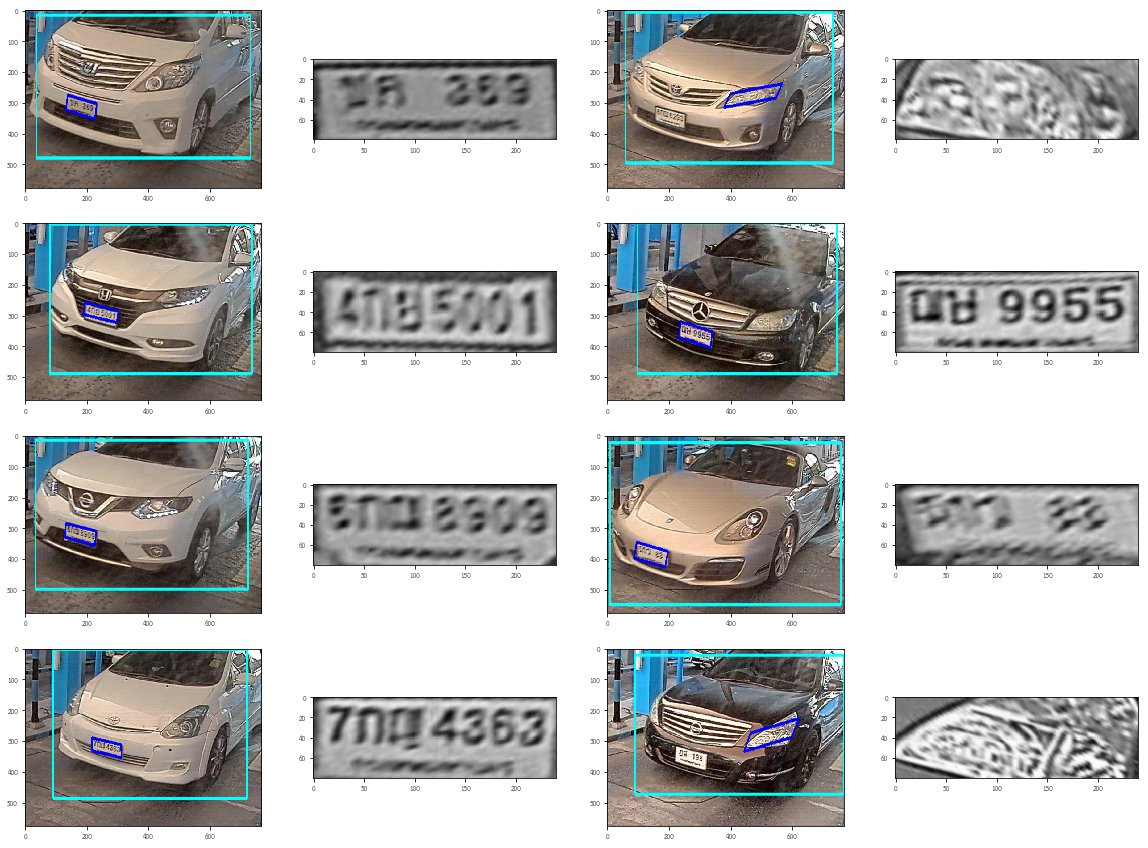

In [18]:
img_files = image_files_from_folder(veh_input_dir)
np.random.shuffle(img_files)
num_imgs = 8
output_imgs = []
lp_imgs = []

for img_file in img_files:
    bname = splitext(basename(img_file))[0]
    detected_cars_labels = '%s/%s_cars.txt' % (veh_output_dir,bname)
    Lcar = lread(detected_cars_labels)
    
    if Lcar:
        sys.stdout.write('%s\n' % bname)
        I = cv2.imread(img_file)
        for i,lcar in enumerate(Lcar):
            draw_label(I,lcar,color=YELLOW,thickness=3)
            lp_label = '%s/%s_%dcar_lp.txt' % (veh_output_dir,bname,i)
            lp_label_str = '%s/%s_%dcar_lp_str.txt' % (veh_output_dir,bname,i)
            lp_img = '%s/%s_%dcar_lp.png' % (veh_output_dir,bname,i)
            
            if isfile(lp_label):
                Llp_shapes = readShapes(lp_label)
                pts = Llp_shapes[0].pts*lcar.wh().reshape(2,1) + lcar.tl().reshape(2,1)
                ptspx = pts*np.array(I.shape[1::-1],dtype=float).reshape(2,1)
                draw_losangle(I,ptspx,RED,3)
                
                if isfile(lp_label_str):
                    with open(lp_label_str,'r') as f:
                        lp_str = f.read().strip()
                    llp = Label(0,tl=pts.min(1),br=pts.max(1))
                    write2img(I,llp,lp_str)
                    sys.stdout.write(',%s' % lp_str)
                cv2.imwrite('%s/%s_output.png' % (veh_output_dir,bname),I)
                #sys.stdout.write('\n')
                output_imgs.append(I)
                
                lp_im = cv2.imread(lp_img)
                lp_imgs.append(lp_im)
                if len(output_imgs) >= num_imgs:
                    break

plt.figure(figsize=(20,15))
for i in range(num_imgs):
    h, w, _ = output_imgs[i].shape
    if w/float(h) > 2:
        output_imgs[i] = cv2.resize(output_imgs[i], (w,h*2))
    plt.subplot(4,4,i*2+1)
    plt.imshow(output_imgs[i])
    plt.subplot(4,4,i*2+2)
    plt.imshow(lp_imgs[i])
    #plt.title('%d, %s' % (ids[i], label_csv.CSCV_PLATE_NO[ids[i]]), fontsize=20)
plt.show()